In [347]:
include("../../ofdm.jl")
include("../CPR.jl")
include("../../../../Channel/Channel.jl")

Main.Channel

In [348]:
using Plots, BenchmarkTools, LinearAlgebra, FFTW

In [349]:
params = Ofdm.OfdmParams(64,0,12,6,(1,1), pilot_type=:comb, pilot_space=4, pilot_interval=2)

Main.Ofdm.OfdmParams(64, 0, 64, 1, 1, (58, 46), 12, 6, :comb, 4, 2, [1])

In [350]:
indices = Ofdm.get_index(params)

Dict{Symbol,Array{Int64,N} where N} with 2 entries:
  :pilot => [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54]
  :null  => [1, 2, 32, 62, 63, 64]

In [351]:
frame = Ofdm.gen_frame(params, indices, 30);

In [352]:
M = 4; nbits=1000; ndim=(1,1)
qam = Ofdm.QamMod(M);
pdp = [1.0, 0.0, 0.0, 0.0 , 1.0] / 2.0
# pdp = Channel.exponent(1,20);

In [353]:
tx_bit = rand(nbits) .> 0.5
tx_symbol = Ofdm.qammod(qam, tx_bit)
tx_ofdmsig = Ofdm.ofdmmod(params, frame, tx_symbol, indices);

In [354]:
tx_frame = Ofdm.data_mapping(params, frame, tx_symbol, indices);

In [355]:
rx_ofdmsig, cir = Channel.multipath_fading(tx_ofdmsig, ndim, pdp, 0.0, istail=false);

In [356]:
rx_frame = Ofdm.ofdmdemod(params, rx_ofdmsig);

In [357]:
cfr = Ofdm.cfr_ideal(cir, 64, size(rx_frame,2));

In [358]:
rind = setdiff(1:64, indices[:null]);
dind = setdiff(1:64, indices[:null]);

In [359]:
current_symbol = tx_frame[:,2,1:1];
previous_symbol = tx_frame[:,1,1:1];

In [360]:
F = fft!(Array{ComplexF64}(I,params.nfft,params.nfft),1);

In [362]:
# CPR.cpr(view(rx_frame,:,2,1:1), cir, current_symbol, previous_symbol, 64,0, rind, dind,64, :freq)

  61.500 μs (45 allocations: 66.84 KiB)


In [346]:
@time for j in axes(rx_frame,2)
    if j == 1
        current_symbol = view(tx_frame,:,j,1);
        previous_symbol = nothing
        CPR.cpr(view(rx_frame,:,j,1), cir, previous_symbol, current_symbol, 64,0, rind, dind, 64)
    else
        current_symbol = view(tx_frame,:,j,1);
        previous_symbol = view(tx_frame,:,j-1,1);
        CPR.cpr(view(rx_frame,:,j,1), cir, previous_symbol, current_symbol, 64,0, rind, dind, 64)
    end
end
    

  0.000679 seconds (488 allocations: 670.203 KiB)


In [1740]:
size(rx_frame[:,1:1,:])

(64, 1, 1)

In [1741]:
Ofdm.equalize(params, rx_frame[:,1:1,:], cfr[:,1:1,:,:], indices[:frame][:,1:1,:])

46-element Array{Complex{Float64},1}:
  0.7071067811865478 + 0.7071067811865474im
  0.7071067811865479 - 0.7071067811865475im
  0.7071067811865468 + 0.7071067811865471im
 -0.7071067811865471 + 0.7071067811865471im
 -0.7071067811865466 + 0.7071067811865477im
 -0.7071067811865482 - 0.7071067811865476im
  0.7071067811865479 - 0.7071067811865475im
 -0.7071067811865472 + 0.7071067811865474im
   0.707106781186547 + 0.7071067811865475im
 -0.7071067811865477 + 0.7071067811865474im
  0.7071067811865478 + 0.7071067811865477im
  -0.707106781186547 + 0.7071067811865471im
   0.707106781186547 - 0.7071067811865476im
                     ⋮                     
 -0.7071067811865477 + 0.7071067811865476im
  0.7071067811865475 + 0.7071067811865471im
 -0.7071067811865474 + 0.7071067811865478im
 -0.7071067811865474 + 0.7071067811865474im
  0.7071067811865472 - 0.7071067811865475im
  0.7071067811865469 - 0.7071067811865475im
 -0.7071067811865471 - 0.7071067811865475im
  0.7071067811865478 - 0.7071067811865

チャネル利得の比較

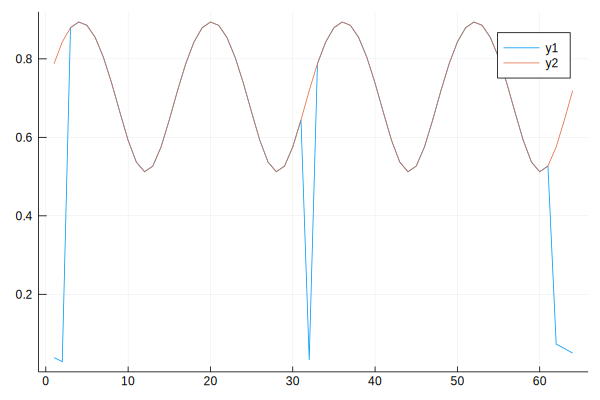

In [311]:
plot(abs.(rx_frame[:,2,1]))
plot!(abs.(cfr[:,1,1,1]))